# Lab 03: Text Classification on the DBpedia14 dataset

### Objectives:
1. Build a Naive Bayes classification model from scratch
2. Evaluate the performance of your model on the DBpedia14 dataset
3. Train an off-the-shelf NB classifier and compare its performance to your implementation
4. Train off-the-shelf implementations of the linear-SVM, RBF-kernel-SVM, and perceptron and compare their performance with the NB models

### Suggested Reading

1. https://arxiv.org/pdf/1811.12808.pdf

### Download the dataset

In [1]:
import datasets
import pandas as pd

train_ds, test_ds = datasets.load_dataset('dbpedia_14', split=["train", "test"], ignore_verifications=True)
df_train: pd.DataFrame = train_ds.to_pandas()
df_test: pd.DataFrame = test_ds.to_pandas()

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Dataset dbpedia_14 downloaded and prepared to C:\Users\cml\.cache\huggingface\datasets\dbpedia_14\dbpedia_14\2.0.0\01dab9e10d969eadcdbc918be5a09c9190a24caeae33b10eee8f367a1e3f1f0c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Part I: Build your own Naive Bayes classification model

### (10 pts) Task I: Build a model from scratch
Using your notes from lecture-02, implement a Naive Bayes model and train it on the DBpedia dataset. Also, feel free to use any text preprocessing you wish, such as the pipeline from Lab02. 

Below is a template class to help you think about the structure of this problem (feel free to design your own code if you like). It contains methods for each inference step in NB. It also has a classmethod that you could use to instantiate the class from a list of documents and a corresponding list of labels. Here we are suggesting you create a dictionary that maps each word to a unique $ith$ index in the $\phi_{i,k}$ probabilty matrix, which you need to estimate. Because the labels are a set of 0-indexed integers, they naturally map to a unique position $\mu_{k}$ (you should check this to make sure).

In [222]:
from typing import Union, List
import numpy as np


class NaiveBayesModel:
    
    """Multinomial NB model class template"""
    
    #phi: np.ndarray # (N, K)
    
    #mu: np.ndarray  # (K,)
    
    #vocab: dict     # vocabulary map from word to row index in phi
    
    #n_class: int    # number of classes
    
    def __init__(self, vocabulary: dict={}, num_classes: int = 0):
        """
        Parameters
        ----------
        vocabulary: {str: int} <- {word: index}
        num_classes: Number of classes
        """
        self.vocab = {x:vocabulary[x] for x in vocabulary.keys()}
        self.n_class = num_classes
        self.mu = np.zeros(num_classes)
        self.phi = np.zeros((len(vocabulary), num_classes))
        

    def from_preprocessed_data(self, docs_list: List[str], labels_list: List[int]):
        self.vocab = {word: idx for idx, word in enumerate(set(" ".join(docs_list).split(" ")))}
        self.n_class = len(set(labels_list))
        Xtr = np.zeros((len(docs_list), len(self.vocab)))
        for i, doc in enumerate(docs_list):
            for word in doc.split(" "):
                j = self.vocab[word]
                Xtr[i, j] += 1
        self.estimate_mu(labels_list)
        self.estimate_phi(Xtr, labels_list)
        
    def estimate_mu(self, labels_list: List[int], alpha: float = 1.):
        """
        Estimate P(Y), the prior over labels
        Parameters
        ----------
        alpha: smoothing parameter
        """
        #print(np.array([(sum(labels_list == idx) + alpha) / (len(labels_list) + self.n_class * alpha) for idx in range(self.n_class)]))
        self.mu = np.array([(sum(labels_list == idx) + alpha) / (len(labels_list) + self.n_class * alpha) for idx in range(self.n_class)])
        #setattr(self, 'mu', np.array([(sum(labels_list == idx) + alpha) / (len(labels_list) + self.n_class * alpha) for idx in range(self.n_class)]))
        
    def estimate_phi(self, Xtr: np.ndarray, labels_list: List[int], alpha: float = 1.):
        """
        Estimate phi, the N x K matrix 
        describing the probability of
        the nth word in the kth class.
    
        Parameters
        ----------
        alpha: smoothing parameter
        """
        word_count_by_class = {k: np.sum(Xtr[np.where(labels_list == k)]) for k in range(self.n_class)}
        self.phi = np.zeros(shape=(self.n_class, len(self.vocab)))
        for word, j in self.vocab.items():
            for k in range(self.n_class):
                num_word_j_class_k = sum(np.squeeze(Xtr[np.where(labels_list == k), j]))
                self.phi[k, j] = (alpha + num_word_j_class_k) / (alpha * len(labels_list) + word_count_by_class[k])
        #setattr(self, 'phi', phi_hat)
    
    def predict_label(self, text: str) -> int:
        """
        Compute label given some input text
        
        Parameters
        ----------
        text: raw input text
        
        Returns
        -------
        int: corresponding to the predicted label
        """
        Xte = np.zeros(shape=(len(self.vocab)))
        for word in text.split(" "):
            if word in self.vocab.keys():
                j = self.vocab[word]
                Xte[j] += 1
        p_y_given_Xte = Xte.dot(np.log(self.phi).T) + np.log(self.mu)
        return np.argmax(p_y_given_Xte)
    
    def predict_proba(self, text:str)->np.ndarray:
        Xte = np.zeros(shape=(len(self.vocab)))
        for word in text.split(" "):
            if word in self.vocab.keys():
                j = self.vocab[word]
                Xte[j] += 1
        prob = np.exp(Xte.dot(np.log(self.phi).T) + np.log(self.mu))
        prob = prob/prob.sum()
        return prob

In [24]:
import spacy
pipeline = spacy.load('en_core_web_sm')

In [25]:
import re
from spacy.language import Language


# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "numbr"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "),   # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_text = df_train['content']
test_text = df_test['content']

for repl in replace:
    train_text = [re.sub(repl[0], repl[1], text) for text in train_text]
    test_text = [re.sub(repl[0], repl[1], text) for text in test_text]

@Language.component("ng20")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)

pipeline.add_pipe("ng20");

In [93]:
import random as rd
train_indices = rd.sample(np.arange(df_train.shape[0]).tolist(), 1400)
test_indices = rd.sample(np.arange(df_test.shape[0]).tolist(), 280)
#train_indices = []
#test_indices = []
#for i in range(K):
#    train_indices.extend(rd.sample((np.arange(df_train.shape[0]))[df_train['label']==i].tolist(),100))
#    test_indices.extend(rd.sample((np.arange(df_test.shape[0]))[df_test['label']==i].tolist(),20))

In [97]:
docs_train = [pipeline(doc) for doc in [train_text[i] for i in train_indices]]
docs_test = [pipeline(doc) for doc in [test_text[i] for i in test_indices]]

In [98]:
labels_train = np.array(df_train['label'][train_indices])
labels_test = np.array(df_test['label'][test_indices])

In [223]:
nb_predictor = NaiveBayesModel()
nb_predictor.from_preprocessed_data(docs_train, labels_train)

In [153]:
labels_predicted = []
for text in docs_test:
    labels_predicted.append(nb_predictor.predict_label(text))

In [157]:
sum(labels_predicted==labels_test)/len(labels_test)

0.8785714285714286

# Part II: Model performance evaluation

Evaluating the performance of a classification model may seem as simple as computing an accuracy, and in some cases that is sufficient, but in general accuracy is not a reliable metric by itself. Typically we need to evaluate our model using several different metrics. 

One common issue is class imbalance, which is when the label distribution in the data varies far from uniform. In this case a high accuracy can be misleading because low frequency labels don't contribute equally to the score. More generally, this is one of the biggest drawbacks of using MLE in NLP: models tend to be much less sensitive to low probability labels than to higher probabilty labels. Later in this class we will explore models that learn by predicting words given their context, can you think of reasons why this can be problematic? Hint: remember Zipf's law?

Another reason to use multiple evaluation methods is that it can help you better understand your data. Evaluating performance on individual classes often reveals problems with the data that would otherwise go unnoticed. For example, if you observe an abundance of misclassified data specific to only a few classes, chances are you have inconsistent labels for those classes in the training set. This is very common in 3rd party mechanical turk data, where quality can vary wildly.

In this lab we will use three metrics and one visualization tool:

1. [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)
2. [F1 score](https://en.wikipedia.org/wiki/F-score)
3. [AUC ROC score](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
4. [The confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

The [metrics module](https://scikit-learn.org/stable/modules/model_evaluation.html) within sklearn provides support for nearly any evaluation metric that you will need.

In [152]:
from sklearn import metrics

# Part III: Compare your performance to an off-the-shelf NB classifier
Open source implementations of your custom NB classifier from Part I already exist of course. One such implementation is [`sklearn.naive_bayes.MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) from the sklearn library. 

### (5 pts) Task II: NB model comparison
Train this model on the same data and compare its performance with your model using the metrics from part II.

In [158]:
from sklearn.naive_bayes import MultinomialNB

In [163]:
vocabulary = {word: idx for idx, word in enumerate(set(" ".join(docs_train).split(" ")))}
num_class = len(set(labels_train))
X_train = np.zeros((len(docs_train), len(vocabulary)))
for i, doc in enumerate(docs_train):
    for word in doc.split(" "):
        j = vocabulary[word]
        X_train[i, j] += 1

In [170]:
X_test = np.zeros(shape=(len(docs_test), len(vocabulary)))
for i in range(len(docs_test)):
    for word in docs_test[i].split(" "):
        if word in vocabulary.keys():
            j = vocabulary[word]
            X_test[i,j] += 1         

In [177]:
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train,labels_train)

MultinomialNB()

In [178]:
NB_pred = NB_classifier.predict(X_test)

#### Accuracy

In [181]:
metrics.accuracy_score(labels_test, labels_predicted)

0.8785714285714286

In [182]:
metrics.accuracy_score(labels_test, NB_pred)

0.875

#### F1 Score

In [188]:
metrics.f1_score(labels_test, labels_predicted, average='weighted')

0.8767487207615906

In [189]:
metrics.f1_score(labels_test, NB_pred, average='weighted')

0.8726081647999564

#### ROC AUC Score

In [224]:
myNB_proba = []
for i in range(len(docs_test)):
    myNB_proba.append(nb_predictor.predict_proba(docs_test[i]))

In [226]:
myNB_proba_mat = np.array([])
for i in range(len(docs_test)):
    myNB_proba_mat = np.concatenate((myNB_proba_mat, myNB_proba[i]))
myNB_proba_mat = myNB_proba_mat.reshape((len(docs_test), num_class))

In [207]:
NB_proba_mat = NB_classifier.predict_proba(X_test)

In [229]:
metrics.roc_auc_score(labels_test, myNB_proba_mat, multi_class='ovr')

0.9928711256768453

In [231]:
metrics.roc_auc_score(labels_test, NB_proba_mat, multi_class='ovr')

0.9925956930425629

#### Confusion Matrix

In [232]:
myNB_conf_mat = metrics.confusion_matrix(labels_test, labels_predicted)

In [233]:
NB_conf_mat = metrics.confusion_matrix(labels_test, NB_pred)

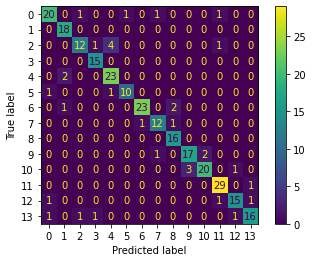

In [237]:
import matplotlib.pyplot as plt
myNB_disp = metrics.ConfusionMatrixDisplay(myNB_conf_mat)
myNB_disp.plot()
plt.show()

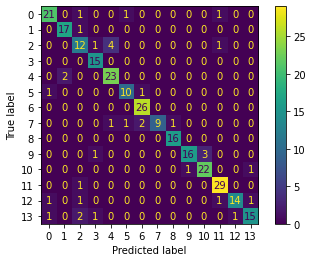

In [238]:
NB_disp = metrics.ConfusionMatrixDisplay(NB_conf_mat)
NB_disp.plot()
plt.show()

# Part IV: Compare NB to other classification models

Now that we've built and validated our NB classifier, we want to evaluate other models on this task.

### (5 pts) Task III: Evaluate the perceptron, SVM (linear), and SVM (RBF kernel)
Train and evaluate the following models on this dataset, and compare them with the NB models.

1. [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)
2. [Linear-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
3. [RBF-Kernel-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [243]:
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [241]:
perceptron_classifier = Perceptron(tol=1e-3, random_state=0)

In [242]:
perceptron_classifier.fit(X_train, labels_train)

Perceptron()

In [248]:
perceptron_pred = perceptron_classifier.predict(X_test)

In [264]:
conf_function = perceptron_classifier.decision_function(X_test)
perceptron_proba = np.array(conf_function)
for i in range(perceptron_proba.shape[0]):
    perceptron_proba[i] = perceptron_proba[i] / perceptron_proba[i].sum()

In [244]:
LinearSVC_classifier = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))

In [245]:
LinearSVC_classifier.fit(X_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [267]:
LinearSVC_pred = LinearSVC_classifier.predict(X_test)

In [268]:
conf_function = LinearSVC_classifier.decision_function(X_test)
LinearSVC_proba = np.array(conf_function)
for i in range(LinearSVC_proba.shape[0]):
    LinearSVC_proba[i] = LinearSVC_proba[i] / LinearSVC_proba[i].sum()

In [246]:
RBFSVM_classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [247]:
RBFSVM_classifier.fit(X_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [270]:
RBFSVM_pred = RBFSVM_classifier.predict(X_test)

In [271]:
conf_function = RBFSVM_classifier.decision_function(X_test)
RBFSVM_proba = np.array(conf_function)
for i in range(RBFSVM_proba.shape[0]):
    RBFSVM_proba[i] = RBFSVM_proba[i] / RBFSVM_proba[i].sum()

#### Accuracy

In [273]:
metrics.accuracy_score(labels_test, perceptron_pred)

0.8464285714285714

In [274]:
metrics.accuracy_score(labels_test, LinearSVC_pred)

0.8642857142857143

In [275]:
metrics.accuracy_score(labels_test, RBFSVM_pred)

0.32857142857142857

#### F1 Score

In [276]:
metrics.f1_score(labels_test, perceptron_pred, average='weighted')

0.8472739831785817

In [277]:
metrics.f1_score(labels_test, LinearSVC_pred, average='weighted')

0.8617532814784543

In [278]:
metrics.f1_score(labels_test, RBFSVM_pred, average='weighted')

0.32465843233219627

#### ROC AUC Score

In [280]:
metrics.roc_auc_score(labels_test, perceptron_proba, multi_class='ovr')

0.02705510778835779

In [281]:
metrics.roc_auc_score(labels_test, LinearSVC_proba, multi_class='ovr')

0.02137633629911543

In [282]:
metrics.roc_auc_score(labels_test, RBFSVM_proba, multi_class='ovr')

0.8242870388704369

#### Confusion Matrix

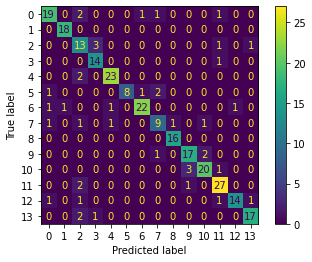

In [283]:
perceptron_conf_mat = metrics.confusion_matrix(labels_test, perceptron_pred)
perceptron_disp = metrics.ConfusionMatrixDisplay(perceptron_conf_mat)
perceptron_disp.plot()
plt.show()

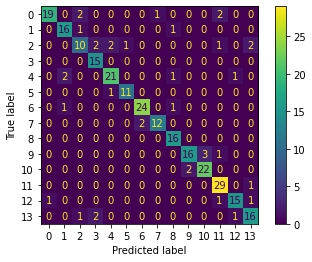

In [284]:
LinearSVC_conf_mat = metrics.confusion_matrix(labels_test, LinearSVC_pred)
LinearSVC_disp = metrics.ConfusionMatrixDisplay(LinearSVC_conf_mat)
LinearSVC_disp.plot()
plt.show()

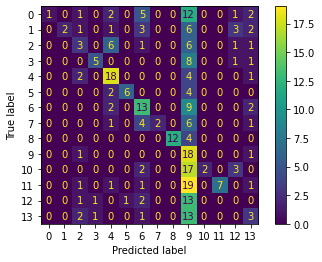

In [285]:
RBFSVM_conf_mat = metrics.confusion_matrix(labels_test, RBFSVM_pred)
RBFSVM_disp = metrics.ConfusionMatrixDisplay(RBFSVM_conf_mat)
RBFSVM_disp.plot()
plt.show()

### (5 pts) Task IV: Select the best model

1. Which model performed the best overall? 
2. What metric(s) influence this decision?
3. Does the model that learns a non-linear decision boundary help?

*1.* In this context the NB model performed best.  
*2.* Since methods for predictions of probability are not provided for Perceptron, LinearSVC and SVC, according to accuracy, F1-score and confusion matrix, we have the NB-model be the best one.  
*3.* Actually not, LinearSVC model performed better that RBFSVC. Probably the RBFSVC model was overfitting on the training set.